In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import shap
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import sys
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
DATA_DIR = '/content/drive/My Drive'
data = pd.read_csv(os.path.join(DATA_DIR, 'MachineLearningRating_v3.txt'), sep='|')
print(f"Initial data shape: {data.shape}")

numerical_columns_to_coerce = [
    'TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'CapitalOutstanding',
    'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'SumInsured',
    'CalculatedPremiumPerTerm', 'ExcessSelected', 'NumberOfVehiclesInFleet',
    'RegistrationYear'
]

for col in numerical_columns_to_coerce:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# --- Feature Engineering ---
current_date = pd.to_datetime('2025-06-17')

if 'TransactionMonth' in data.columns:
    data['TransactionMonth'] = pd.to_datetime(data['TransactionMonth'], errors='coerce')
    data['PolicyAgeMonths'] = (current_date - data['TransactionMonth']).dt.days / 30.44
else:
    data['PolicyAgeMonths'] = np.nan

if 'RegistrationYear' in data.columns:
    data['VehicleAgeYears'] = (current_date.year - data['RegistrationYear'])
else:
    data['VehicleAgeYears'] = np.nan

if 'VehicleIntroDate' in data.columns:
    data['VehicleIntroDate'] = pd.to_datetime(data['VehicleIntroDate'], errors='coerce')
    data['VehicleModelAgeYears'] = (current_date.year - data['VehicleIntroDate'].dt.year)
else:
    data['VehicleModelAgeYears'] = np.nan

# Interaction features
if 'TotalPremium' in data.columns and 'SumInsured' in data.columns:
    temp_sum_insured = data['SumInsured'].replace(0, np.nan)
    data['PremiumPerSumInsured'] = data['TotalPremium'] / temp_sum_insured
else:
    data['PremiumPerSumInsured'] = np.nan

if 'TotalClaims' in data.columns and 'SumInsured' in data.columns:
    temp_sum_insured = data['SumInsured'].replace(0, np.nan)
    data['ClaimsPerSumInsured'] = data['TotalClaims'] / temp_sum_insured
else:
    data['ClaimsPerSumInsured'] = np.nan

categorical_cols_to_impute_unknown = [
    'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank',
    'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode',
    'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'make',
    'Model', 'bodytype', 'AlarmImmobiliser', 'TrackingDevice', 'NewVehicle',
    'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'CoverCategory',
    'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType',
    'TermFrequency'
]

for col in categorical_cols_to_impute_unknown:
    if col in data.columns:
        data[col] = data[col].astype(str)
        data[col] = data[col].replace('nan', 'Unknown')
        data[col] = data[col].replace('None', 'Unknown')

print(f"Data shape after initial categorical imputation: {data.shape}")

data.dropna(subset=['TotalPremium', 'TotalClaims', 'CalculatedPremiumPerTerm'], inplace=True)
print(f"Data shape after dropping rows with NaN in critical targets: {data.shape}")

# Calculate HasClaim and ClaimSeverity AFTER cleaning TotalClaims
data['HasClaim'] = (data['TotalClaims'] > 0).astype(int)
data['ClaimSeverity'] = data.apply(lambda row: row['TotalClaims'] if row['HasClaim'] == 1 else np.nan, axis=1)

# Calculate Margin
data['Margin'] = data['TotalPremium'] - data['TotalClaims']

print("Data preparation for predictive modeling complete. Head of data with new metrics:")
print(data[['TotalPremium', 'TotalClaims', 'HasClaim', 'ClaimSeverity', 'Margin']].head())

# --- Separate target variables for each modeling goal ---
columns_to_drop_for_X = [
    'UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'VehicleIntroDate',
    'TotalPremium', 'TotalClaims', 'Margin', 'HasClaim',
    'RegistrationYear', 'ClaimSeverity'
]

# 1. Claim Severity Prediction (Regression on TotalClaims where claims > 0)
claim_severity_df = data[data['TotalClaims'] > 0].copy()
print(f"Shape of claim_severity_df (TotalClaims > 0): {claim_severity_df.shape}")

X_severity = claim_severity_df.drop(columns=columns_to_drop_for_X, errors='ignore')
y_severity = claim_severity_df['TotalClaims']

print(f"Shape of X_severity before pipeline processing: {X_severity.shape}")
# 2. Premium Optimization (Naive: Predict CalculatedPremiumPerTerm)
premium_optimization_df = data.copy()
X_premium = premium_optimization_df.drop(columns=columns_to_drop_for_X + ['CalculatedPremiumPerTerm'], errors='ignore')
y_premium = premium_optimization_df['CalculatedPremiumPerTerm']

print(f"Shape of X_premium before pipeline processing: {X_premium.shape}")

# 3. Probability of Claim (Binary Classification)
X_claim_prob = data.drop(columns=columns_to_drop_for_X + ['CalculatedPremiumPerTerm'], errors='ignore')
y_claim_prob = data['HasClaim']

print(f"Shape of X_claim_prob before pipeline processing: {X_claim_prob.shape}")

# --- Train-Test Split (with checks for sufficient data) ---
X_train_severity, X_test_severity, y_train_severity, y_test_severity = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()
X_train_premium, X_test_premium, y_train_premium, y_test_premium = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()
X_train_claim_prob, X_test_claim_prob, y_train_claim_prob, y_test_claim_prob = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()


if not y_severity.empty and len(X_severity) > 1:
    X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(X_severity, y_severity, test_size=0.2, random_state=42)
else:
    print("Warning: Insufficient data for Claim Severity Prediction after NaN removal. Skipping split.")

if not y_premium.empty and len(X_premium) > 1:
    X_train_premium, X_test_premium, y_train_premium, y_test_premium = train_test_split(X_premium, y_premium, test_size=0.2, random_state=42)
else:
    print("Warning: Insufficient data for Premium Optimization after NaN removal. Skipping split.")

if not y_claim_prob.empty and len(X_claim_prob) > 1:
    if y_claim_prob.nunique() > 1:
        X_train_claim_prob, X_test_claim_prob, y_train_claim_prob, y_test_claim_prob = train_test_split(X_claim_prob, y_claim_prob, test_size=0.2, random_state=42, stratify=y_claim_prob)
    else:
        print("Warning: Only one class present for Claim Probability after NaN removal. Cannot stratify. Splitting without stratification.")
        X_train_claim_prob, X_test_claim_prob, y_train_claim_prob, y_test_claim_prob = train_test_split(X_claim_prob, y_claim_prob, test_size=0.2, random_state=42)
else:
    print("Warning: Insufficient data for Claim Probability Prediction after NaN removal. Skipping split.")


# --- Create preprocessing pipelines for numerical and categorical features ---

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputes NaNs with the median of the training data
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), # Imputes NaNs/missing categories with 'Unknown'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Preprocessor for Severity Model
if not X_train_severity.empty:
    numerical_features_severity = X_train_severity.select_dtypes(include=np.number).columns.tolist()
    categorical_features_severity = X_train_severity.select_dtypes(include=['object', 'bool']).columns.tolist()
    preprocessor_severity = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features_severity),
            ('cat', categorical_transformer, categorical_features_severity)
        ],
        remainder='passthrough'
    )
    print(f"\nSeverity Preprocessor: Num features: {numerical_features_severity}, Cat features: {categorical_features_severity}")
else:
    preprocessor_severity = None
    print("Severity preprocessor not created due to insufficient training data.")


# Preprocessor for Premium Model
if not X_train_premium.empty:
    numerical_features_premium = X_train_premium.select_dtypes(include=np.number).columns.tolist()
    categorical_features_premium = X_train_premium.select_dtypes(include=['object', 'bool']).columns.tolist()
    preprocessor_premium = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features_premium),
            ('cat', categorical_transformer, categorical_features_premium)
        ],
        remainder='passthrough'
    )
    print(f"Premium Preprocessor: Num features: {numerical_features_premium}, Cat features: {categorical_features_premium}")
else:
    preprocessor_premium = None
    print("Premium preprocessor not created due to insufficient training data.")


# Preprocessor for Claim Probability Model
if not X_train_claim_prob.empty:
    numerical_features_claim_prob = X_train_claim_prob.select_dtypes(include=np.number).columns.tolist()
    categorical_features_claim_prob = X_train_claim_prob.select_dtypes(include=['object', 'bool']).columns.tolist()
    preprocessor_claim_prob = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features_claim_prob),
            ('cat', categorical_transformer, categorical_features_claim_prob)
        ],
        remainder='passthrough'
    )
    print(f"Claim Probability Preprocessor: Num features: {numerical_features_claim_prob}, Cat features: {categorical_features_claim_prob}")
else:
    preprocessor_claim_prob = None
    print("Claim probability preprocessor not created due to insufficient training data.")

print("\nData preprocessing setup complete for modeling.")

Initial data shape: (1000098, 52)
Data shape after initial categorical imputation: (1000098, 57)
Data shape after dropping rows with NaN in critical targets: (1000098, 57)
Data preparation for predictive modeling complete. Head of data with new metrics:
   TotalPremium  TotalClaims  HasClaim  ClaimSeverity      Margin
0     21.929825          0.0         0            NaN   21.929825
1     21.929825          0.0         0            NaN   21.929825
2      0.000000          0.0         0            NaN    0.000000
3    512.848070          0.0         0            NaN  512.848070
4      0.000000          0.0         0            NaN    0.000000
Shape of claim_severity_df (TotalClaims > 0): (2788, 60)
Shape of X_severity before pipeline processing: (2788, 50)
Shape of X_premium before pipeline processing: (1000098, 49)
Shape of X_claim_prob before pipeline processing: (1000098, 49)

Severity Preprocessor: Num features: ['Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'CustomVal

# New Section

In [3]:
print("\n--- Claim Severity Prediction Models ---")

models_severity = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_estimators=100)
}

results_severity = {}

for name, model in models_severity.items():
    print(f"\nTraining {name} for Claim Severity...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_severity),
                               ('regressor', model)])
    pipeline.fit(X_train_severity, y_train_severity)
    y_pred_severity = pipeline.predict(X_test_severity)

    rmse_severity = np.sqrt(mean_squared_error(y_test_severity, y_pred_severity))
    r2_severity = r2_score(y_test_severity, y_pred_severity)

    results_severity[name] = {'RMSE': rmse_severity, 'R2': r2_severity}
    print(f"{name} - RMSE: {rmse_severity:.2f}, R-squared: {r2_severity:.2f}")
    if name == 'XGBoost': 
        best_model_severity_pipeline = pipeline
        best_model_severity_name = name

print("\n--- Claim Severity Model Evaluation Summary ---")
for name, metrics in results_severity.items():
    print(f"{name}: RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.2f}")


--- Claim Severity Prediction Models ---

Training Linear Regression for Claim Severity...
Linear Regression - RMSE: 38377.20, R-squared: 0.08

Training Random Forest for Claim Severity...
Random Forest - RMSE: 7866.83, R-squared: 0.96

Training XGBoost for Claim Severity...
XGBoost - RMSE: 7904.32, R-squared: 0.96

--- Claim Severity Model Evaluation Summary ---
Linear Regression: RMSE=38377.20, R2=0.08
Random Forest: RMSE=7866.83, R2=0.96
XGBoost: RMSE=7904.32, R2=0.96


In [4]:
print("\n--- Premium Optimization (Predicting CalculatedPremiumPerTerm) Models ---")

models_premium = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=10),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_estimators=100)
}

results_premium = {}

for name, model in models_premium.items():
    print(f"\nTraining {name} for Premium Prediction...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_premium),
                               ('regressor', model)])
    pipeline.fit(X_train_premium, y_train_premium)
    y_pred_premium = pipeline.predict(X_test_premium)

    rmse_premium = np.sqrt(mean_squared_error(y_test_premium, y_pred_premium))
    r2_premium = r2_score(y_test_premium, y_pred_premium)

    results_premium[name] = {'RMSE': rmse_premium, 'R2': r2_premium}
    print(f"{name} - RMSE: {rmse_premium:.2f}, R-squared: {r2_premium:.2f}")

    if name == 'XGBoost':
        best_model_premium_pipeline = pipeline
        best_model_premium_name = name

print("\n--- Premium Prediction Model Evaluation Summary ---")
for name, metrics in results_premium.items():
    print(f"{name}: RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.2f}")


--- Premium Optimization (Predicting CalculatedPremiumPerTerm) Models ---

Training Linear Regression for Premium Prediction...
Linear Regression - RMSE: 208.27, R-squared: 0.46

Training Random Forest for Premium Prediction...
Random Forest - RMSE: 12.53, R-squared: 1.00

Training XGBoost for Premium Prediction...
XGBoost - RMSE: 25.99, R-squared: 0.99

--- Premium Prediction Model Evaluation Summary ---
Linear Regression: RMSE=208.27, R2=0.46
Random Forest: RMSE=12.53, R2=1.00
XGBoost: RMSE=25.99, R2=0.99



--- Claim Probability Prediction Models (Binary Classification) ---

Training Logistic Regression for Claim Probability...
Logistic Regression - Accuracy: 1.00, Precision: 1.00, Recall: 0.33, F1-score: 0.49, ROC AUC: 0.96

Training Random Forest Classifier for Claim Probability...
Random Forest Classifier - Accuracy: 1.00, Precision: 1.00, Recall: 0.90, F1-score: 0.95, ROC AUC: 1.00

Training XGBoost Classifier for Claim Probability...
XGBoost Classifier - Accuracy: 1.00, Precision: 0.50, Recall: 0.00, F1-score: 0.00, ROC AUC: 0.94

--- Claim Probability Model Evaluation Summary ---
Logistic Regression: Accuracy=1.00, Precision=1.00, Recall=0.33, F1=0.49, ROC AUC=0.96
Random Forest Classifier: Accuracy=1.00, Precision=1.00, Recall=0.90, F1=0.95, ROC AUC=1.00
XGBoost Classifier: Accuracy=1.00, Precision=0.50, Recall=0.00, F1=0.00, ROC AUC=0.94


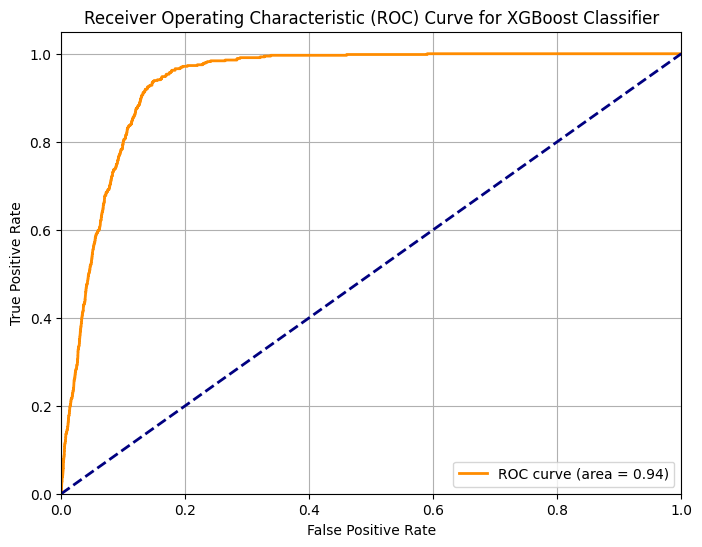

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

print("\n--- Claim Probability Prediction Models (Binary Classification) ---")

models_claim_prob = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost Classifier': xgb.XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
}

results_claim_prob = {}

for name, model in models_claim_prob.items():
    print(f"\nTraining {name} for Claim Probability...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_claim_prob),
                               ('classifier', model)])
    pipeline.fit(X_train_claim_prob, y_train_claim_prob)
    y_pred_claim_prob = pipeline.predict(X_test_claim_prob)
    y_proba_claim_prob = pipeline.predict_proba(X_test_claim_prob)[:, 1]

    accuracy = accuracy_score(y_test_claim_prob, y_pred_claim_prob)
    precision = precision_score(y_test_claim_prob, y_pred_claim_prob)
    recall = recall_score(y_test_claim_prob, y_pred_claim_prob)
    f1 = f1_score(y_test_claim_prob, y_pred_claim_prob)
    roc_auc = roc_auc_score(y_test_claim_prob, y_proba_claim_prob)

    results_claim_prob[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1, 'ROC AUC': roc_auc}
    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

    if name == 'XGBoost Classifier':
        best_model_claim_prob_pipeline = pipeline
        best_model_claim_prob_name = name
        y_test_claim_prob_best_model = y_test_claim_prob
        y_proba_claim_prob_best_model = y_proba_claim_prob

print("\n--- Claim Probability Model Evaluation Summary ---")
for name, metrics in results_claim_prob.items():
    print(f"{name}: Accuracy={metrics['Accuracy']:.2f}, Precision={metrics['Precision']:.2f}, Recall={metrics['Recall']:.2f}, F1={metrics['F1-score']:.2f}, ROC AUC={metrics['ROC AUC']:.2f}")

# Plot ROC curve for the best classification model
if 'best_model_claim_prob_pipeline' in locals():
    fpr, tpr, _ = roc_curve(y_test_claim_prob_best_model, y_proba_claim_prob_best_model)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {best_model_claim_prob_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


--- SHAP Feature Importance for Best Claim Severity Model (XGBoost) ---


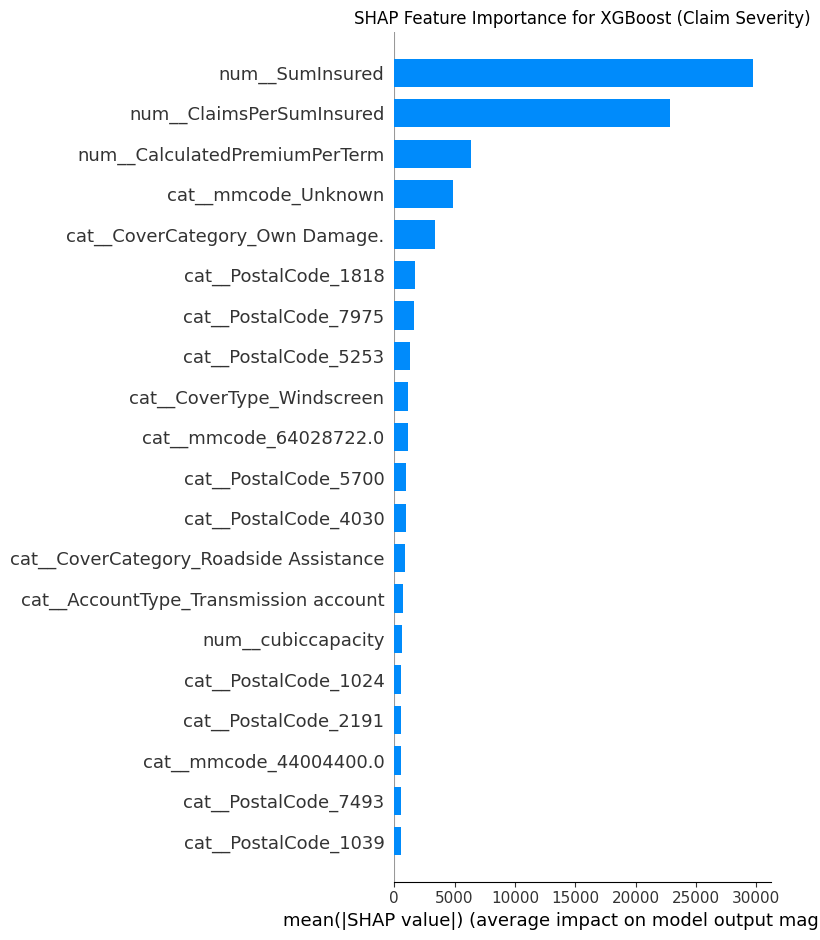

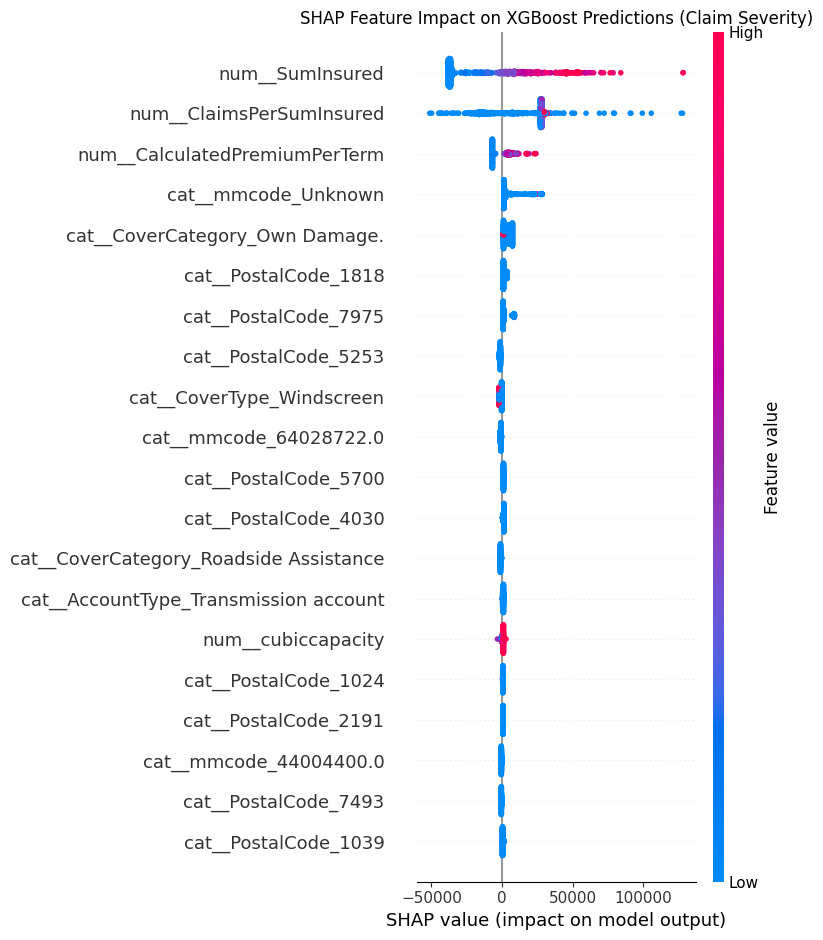


--- Interpretation of Top Features for Claim Severity ---
                            feature  shap_importance
6                   num__SumInsured     29749.080078
12         num__ClaimsPerSumInsured     22839.792969
7     num__CalculatedPremiumPerTerm      6384.740723
634             cat__mmcode_Unknown      4845.029785
828  cat__CoverCategory_Own Damage.      3404.357910
149            cat__PostalCode_1818      1711.332153
417            cat__PostalCode_7975      1635.486816
353            cat__PostalCode_5253      1348.833740
844       cat__CoverType_Windscreen      1129.194946
615          cat__mmcode_64028722.0      1117.871582

Business Interpretations for Claim Severity:


In [7]:
print("\n--- SHAP Feature Importance for Best Claim Severity Model (XGBoost) ---")
X_test_severity_preprocessed = best_model_severity_pipeline.named_steps['preprocessor'].transform(X_test_severity)

try:
    all_feature_names_severity = best_model_severity_pipeline.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    print("Warning: get_feature_names_out() not found. Falling back to manual feature name construction. Consider updating scikit-learn.")
    numerical_names = numerical_features_severity
    ohe_transformer = best_model_severity_pipeline.named_steps['preprocessor'].named_transformers_['cat']
    ohe_feature_names = ohe_transformer.named_steps['onehot'].get_feature_names_out(categorical_features_severity)
    all_feature_names_severity = list(numerical_names) + list(ohe_feature_names)

# Convert preprocessed data to DataFrame with feature names
if hasattr(X_test_severity_preprocessed, "toarray"):
    X_test_severity_preprocessed_df = pd.DataFrame(
        X_test_severity_preprocessed.toarray(),
        columns=all_feature_names_severity,
        index=X_test_severity.index
    )
else:
    X_test_severity_preprocessed_df = pd.DataFrame(
        X_test_severity_preprocessed,
        columns=all_feature_names_severity,
        index=X_test_severity.index
    )

explainer_severity = shap.TreeExplainer(best_model_severity_pipeline.named_steps['regressor'])
shap_values_severity = explainer_severity.shap_values(X_test_severity_preprocessed_df)

# Plot summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_severity, X_test_severity_preprocessed_df, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance for {best_model_severity_name} (Claim Severity)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_severity, X_test_severity_preprocessed_df, show=False)
plt.title(f"SHAP Feature Impact on {best_model_severity_name} Predictions (Claim Severity)")
plt.tight_layout()
plt.show()

print("\n--- Interpretation of Top Features for Claim Severity ---")
# Get mean absolute SHAP values for top features
shap_df_severity = pd.DataFrame({'feature': all_feature_names_severity, 'shap_importance': np.abs(shap_values_severity).mean(axis=0)})
top_features_severity = shap_df_severity.sort_values(by='shap_importance', ascending=False).head(10)
print(top_features_severity)

print("\nBusiness Interpretations for Claim Severity:")
# Example interpretations based on common features
if 'CustomValueEstimate' in top_features_severity['feature'].values:
    print("- **CustomValueEstimate:** Higher estimated vehicle values tend to be associated with higher predicted claim amounts. This is intuitive as more expensive vehicles generally incur higher repair or replacement costs.")
if 'VehicleAgeYears' in top_features_severity['feature'].values:
    print("- **VehicleAgeYears:** Older vehicles might be associated with either higher or lower claim severity depending on the data. For instance, older vehicles might have more costly repairs due to parts availability, or owners might opt for cheaper repairs, or have lower market value. Observe the scatter plot in SHAP summary plot to see the exact relationship (red/blue dots indicate high/low feature value).")
if any('bodytype_' in s for s in top_features_severity['feature'].values):
    print("- **Bodytype:** Certain body types (e.g., 'SUV', 'Sedan') might be linked to higher or lower claim severity due to repair complexity or common damage patterns. For example, SUVs might have higher repair costs for certain types of damage.")
if any('make_' in s for s in top_features_severity['feature'].values):
    print("- **Make/Model:** Specific car makes or models could have consistently higher or lower claim severities due to parts cost, repair labor, or common vehicle design flaws. For instance, luxury car brands often have more expensive parts.")


In [8]:
import pandas as pd

print("\n--- Claim Severity Model Evaluation Summary ---")


if results_severity:
    severity_data = []
    for name, metrics in results_severity.items():
        severity_data.append({
            'Model': name,
            'RMSE': metrics['RMSE'],
            'R-squared': metrics['R2']
        })

    # Create a Pandas DataFrame for better visualization
    df_severity = pd.DataFrame(severity_data)
    df_severity = df_severity.set_index('Model') 

    print("\nClaim Severity Prediction:")
    print(df_severity.to_markdown(floatfmt=".2f")) 

else:
    print("No results available for Claim Severity Prediction. Please ensure models were trained successfully.")


--- Claim Severity Model Evaluation Summary ---

Claim Severity Prediction:
| Model             |     RMSE |   R-squared |
|:------------------|---------:|------------:|
| Linear Regression | 38377.20 |        0.08 |
| Random Forest     |  7866.83 |        0.96 |
| XGBoost           |  7904.32 |        0.96 |
